# Water Demand Prediction with Amazon SageMaker Autopilot


---

This notebook's CI test result for ap-southeast-2 is as follows. CI test results in other regions can be found at the end of the notebook. 

![This us-west-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/us-west-2/autopilot|autopilot_california_housing.ipynb)

---

_**Using Autopilot to Predict House Prices in California**_


Kernel `Python 3 (Data Science)` works well with this notebook. You will have the best experience running this within SageMaker Studio.

---

## Contents

1. [Introduction](#Introduction)
1. [Setup](#Setup)
1. [Prepare Training Data](#Data)
1. [Train](#Settingup)
1. [Autopilot Results](#Results)
1. [Evaluate Using Test Data](#Evaluate)
1. [Cleanup](#Cleanup)


---

## Introduction

Amazon SageMaker Autopilot is an automated machine learning (commonly referred to as AutoML) solution for tabular datasets. You can use SageMaker Autopilot in different ways: on autopilot (without any human input) or with human guidance, without code through SageMaker Studio or scripted using the AWS SDKs. This notebook will use the AWS SDKs to simply create and deploy a machine learning model without doing any feature engineering manually. We will also explore the auto-generated feature importance report.

Demand modelling is done per location. Features for demand forecasting:

* ```doy```
* ```Aquifer```
* ```PE```
* ```month```
* ```mday```
* ```is_holiday```
* ```wday```
* ```API```
* ```lagAPI```
* ```Tmax```
* ```Tmaxlag1```
* ```Sun```
* ```Sunlag1```
* ```WVRain```
* ```KerburnRain```
* ```Rain_L7DAYS```
* ```Rain_L6DAYS```
* ```Rain_L5DAYS```
* ```Rain_L4DAYS```
* ```Rain_L3DAYS```
* ```Rain_L2DAYS```
* ```Rain_L1DAYS```
* ```Season```
* ```Rainlag1```
* ```Rainlag2```
* ```Rainlag3```
* ```PElag1```
* ```PElag2```
* ```PElag3```
* ```ANcyc```
* ```storage```
* ```Storagelag1```
* ```(site name) fTemp```
* ```(site name) fPrecp```
* ```(site name) cm```
* ```(site name) stat```
* ```Restriction level```
* ```site name```(target)

What we're going to try to predict is the site water demand for a wellington region. We will let Autopilot perform feature engineering, model selection, model tuning, and give us the best candidate model ready to use for inferences.

---
## Setup

_This notebook was created and tested on a ml.m5.large notebook instance._

Let's start by specifying:

- The S3 bucket and prefix to use for training and model data.  This should be within the same region as the Notebook Instance, training, and hosting. The following code will use SageMaker's default S3 bucket (and create one if it doesn't exist).
- The IAM role ARN used to give training and hosting access to your data. See the documentation for how to create these. The following code will use the SageMaker execution role.

In [1]:
import sagemaker
import boto3
from sagemaker import get_execution_role

region = boto3.Session().region_name

session = sagemaker.Session()

# You can modify the following to use a bucket of your choosing
bucket = session.default_bucket()
prefix = "sagemaker/autopilot-water-demand-prediction"

role = get_execution_role()

# This is the client we will use to interact with SageMaker Autopilot
sm = boto3.Session().client(service_name="sagemaker", region_name=region)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


Next, we'll import the Python libraries we'll need for the remainder of the exercise.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
from urllib.parse import urlparse
import time

---
## Prepare Training Data<a name="Data"></a>

We will use available training data stored in S3, date range is from 2006-01-01 to 2024-08-31. Training data prep procedure is the same as the inference data.

In [3]:
from io import StringIO

s3 = boto3.client("s3")

def list_csv_files(bucket_name, key_path):
    # List objects within the specified bucket and prefix
    response = s3.list_objects_v2(Bucket=bucket_name, Prefix=key_path)
    # Filter out the CSV files
    csv_files = [content['Key'] for content in response.get('Contents', []) if content['Key'].endswith('.csv')]
    return csv_files

def read_csv_files_to_dataframes(bucket_name, csv_files):
    dataframes = []
    for key in csv_files:
        # Get the object from S3
        obj = s3.get_object(Bucket=bucket_name, Key=key)
        # Read the CSV file content
        data = obj['Body'].read().decode('utf-8')
        # Convert to DataFrame
        df = pd.read_csv(StringIO(data))
        dataframes.append(df)
    return dataframes

# Example usage
bucket_name = 'niwa-water-demand-modelling'
key_path = 'TrainingData/'
csv_files = list_csv_files(bucket_name, key_path)
df_list = read_csv_files_to_dataframes(bucket_name, csv_files)

In [4]:
csv_files

['TrainingData/Lower Hutt.csv',
 'TrainingData/North Wellington Moa.csv',
 'TrainingData/North Wellington Porirua.csv',
 'TrainingData/Petone.csv',
 'TrainingData/Porirua.csv',
 'TrainingData/Upper Hutt.csv',
 'TrainingData/Wainuiomata.csv',
 'TrainingData/Wellington High Moa.csv',
 'TrainingData/Wellington High Western.csv',
 'TrainingData/Wellington Low Level.csv']

In [5]:
df_list[0].head()

,Date,doy,Aquifer,PE,month,mday,is_holiday,wday,API,lagAPI,...,PElag3,ANcyc,storage,Storagelag1,Lower Hutt fTemp,Lower Hutt fPrecp,Lower Hutt cm,Lower Hutt stat,Lower Hutt,Restriction level
0,2006-01-01,1.0,0.0,4.0,1.0,31.0,1.0,6.0,5.597142,6.996428,...,4.0,0.999852,6.270848,7.659231,0.778843,0.756783,1.13142,202.0,245.474558,1.0
1,2006-01-02,2.0,0.0,4.0,1.0,31.0,1.0,0.0,4.477714,5.597142,...,4.0,0.999407,5.134136,6.270848,0.829385,0.735034,1.13142,181.0,189.061866,1.0
2,2006-01-03,3.0,7.0,4.0,1.0,31.0,1.0,1.0,10.582171,4.477714,...,4.0,0.998667,10.547899,5.134136,0.762252,0.728020,1.13142,187.0,277.001088,1.0
3,2006-01-04,4.0,4.0,4.0,1.0,31.0,0.0,2.0,12.465737,10.582171,...,4.0,0.997630,12.261274,10.547899,0.762252,0.728508,1.13142,261.0,241.740664,1.0
4,2006-01-05,5.0,2.4,4.0,1.0,31.0,0.0,3.0,12.372589,12.465737,...,4.0,0.996298,12.213913,12.261274,0.745922,0.729685,1.13142,252.0,208.878422,1.0


In [6]:
for csv_file, df in zip(csv_files, df_list):
    target = csv_file.split("/")[-1].split(".csv")[0]
    columns = [e for e in df.columns if e != "Date"]


In [8]:
columns, target

(['doy',
  'Aquifer',
  'PE',
  'month',
  'mday',
  'is_holiday',
  'wday',
  'API',
  'lagAPI',
  'Tmax',
  'Tmaxlag1',
  'Sun',
  'Sunlag1',
  'WVRain',
  'KerburnRain',
  'Rain_L7DAYS',
  'Rain_L6DAYS',
  'Rain_L5DAYS',
  'Rain_L4DAYS',
  'Rain_L3DAYS',
  'Rain_L2DAYS',
  'Season',
  'Rainlag1',
  'Rainlag2',
  'Rainlag3',
  'PElag1',
  'PElag2',
  'PElag3',
  'ANcyc',
  'storage',
  'Storagelag1',
  'Wellington Low Level fTemp',
  'Wellington Low Level fPrecp',
  'Wellington Low Level cm',
  'Wellington Low Level stat',
  'Wellington Low Level',
  'Restriction level'],
 'Wellington Low Level')

Before starting an Autopilot job, it is good practice to inspect the data to ensure there are no obvious issues with it. 

In [9]:
pd.set_option("display.max_columns", 500)
df

,Date,doy,Aquifer,PE,month,mday,is_holiday,wday,API,lagAPI,Tmax,Tmaxlag1,Sun,Sunlag1,WVRain,KerburnRain,Rain_L7DAYS,Rain_L6DAYS,Rain_L5DAYS,Rain_L4DAYS,Rain_L3DAYS,Rain_L2DAYS,Season,Rainlag1,Rainlag2,Rainlag3,PElag1,PElag2,PElag3,ANcyc,storage,Storagelag1,Wellington Low Level fTemp,Wellington Low Level fPrecp,Wellington Low Level cm,Wellington Low Level stat,Wellington Low Level,Restriction level
0,2006-01-01,1.0,0.0,4.0,1.0,31.0,1.0,6.0,5.597142,6.996428,21.0,23.0,8.8,13.2,0.000000,7.0,3.2,2.0,2.0,2.0,2.000000e+00,1.000000e+00,4.0,1.0,1.0,0.0,4.0,4.0,4.0,0.999852,6.270848,7.659231,1.555585,0.992720,1.080511,199.000000,267.710740,1.0
1,2006-01-02,2.0,0.0,4.0,1.0,31.0,1.0,0.0,4.477714,5.597142,24.0,21.0,6.9,8.8,0.000000,5.0,2.0,2.0,2.0,2.0,1.000000e+00,0.000000e+00,4.0,0.0,1.0,1.0,4.0,4.0,4.0,0.999407,5.134136,6.270848,1.556436,0.988433,1.080511,174.000000,260.434133,1.0
2,2006-01-03,3.0,7.0,4.0,1.0,31.0,1.0,1.0,10.582171,4.477714,20.0,24.0,11.2,6.9,0.238095,17.0,2.0,2.0,2.0,1.0,1.350031e-13,3.552714e-15,4.0,0.0,0.0,1.0,4.0,4.0,4.0,0.998667,10.547899,5.134136,1.555306,0.975961,1.080511,185.000000,289.456488,1.0
3,2006-01-04,4.0,4.0,4.0,1.0,31.0,0.0,2.0,12.465737,10.582171,20.0,20.0,13.0,11.2,10.619048,0.0,9.0,9.0,8.0,7.0,7.000000e+00,7.000000e+00,4.0,7.0,0.0,0.0,4.0,4.0,4.0,0.997630,12.261274,10.547899,1.555306,0.981194,1.080511,275.000000,284.305497,1.0
4,2006-01-05,5.0,2.4,4.0,1.0,31.0,0.0,3.0,12.372589,12.465737,19.0,20.0,8.2,13.0,0.000000,1.0,13.0,12.0,11.0,11.0,1.100000e+01,4.000000e+00,4.0,4.0,7.0,0.0,4.0,4.0,4.0,0.996298,12.213913,12.261274,1.555033,0.984338,1.080511,272.000000,298.670957,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6813,2024-08-27,240.0,9.8,1.0,8.0,31.0,0.0,1.0,48.272394,48.090492,15.0,14.0,2.2,0.3,35.904762,0.0,46.2,45.0,43.6,38.0,3.460000e+01,2.120000e+01,2.0,21.2,13.4,3.4,1.0,2.0,2.0,-0.563151,46.686113,46.173812,1.554008,1.000000,0.950382,247.771364,226.308021,0.0
6814,2024-08-28,241.0,3.0,2.0,8.0,31.0,0.0,2.0,41.617915,48.272394,16.0,15.0,9.1,2.2,5.571429,0.0,54.8,53.4,47.8,44.4,3.100000e+01,9.800000e+00,2.0,9.8,21.2,13.4,1.0,1.0,2.0,-0.548843,40.942395,46.686113,1.554251,1.000000,0.950382,204.084069,269.911128,0.0
6815,2024-08-29,242.0,5.6,2.0,8.0,31.0,0.0,3.0,38.894332,41.617915,14.0,16.0,0.0,9.1,2.285714,0.0,56.4,50.8,47.4,34.0,1.280000e+01,3.000000e+00,2.0,3.0,9.8,21.2,2.0,1.0,1.0,-0.534373,38.596337,40.942395,1.553773,1.000000,0.950382,256.838591,316.345774,0.0
6816,2024-08-30,243.0,3.2,2.0,8.0,31.0,0.0,4.0,34.315466,38.894332,15.0,14.0,10.0,0.0,8.095238,7.0,56.4,53.0,39.6,18.4,8.600000e+00,5.600000e+00,2.0,5.6,3.0,9.8,2.0,2.0,1.0,-0.519744,34.500316,38.596337,1.554008,0.993601,0.950382,235.982307,240.402610,0.0


Notice that the various columns have values in different ranges. For example, values under the target column ```Wellington Low Level``` are orders of magnitude higher than other columns. This difference in scale often causes issues when training an ML model, which is why it's a common feature engineering practice to normalize or standardize values (depending on the nature of the numeric distribution and presence of outliers).

However, because Autopilot handles feature engineering automatically (among other things), we're not going to make any analysis or transformations ourselves.

To also illustrate how Autopilot handles data issues, such as missing values, let's introduce some random empty values in our dataset for the housing median age column.


In [11]:
# Split data for training and testing (80/20 split)
num_rows = int(len(df) * 0.8)
train_data = df[columns].iloc[:num_rows]
test_data = df[columns].drop(train_data.index)
test_data_no_target = test_data.drop(columns=[target])

In [38]:
test_data

,doy,Aquifer,PE,month,mday,is_holiday,wday,API,lagAPI,Tmax,Tmaxlag1,Sun,Sunlag1,WVRain,KerburnRain,Rain_L7DAYS,Rain_L6DAYS,Rain_L5DAYS,Rain_L4DAYS,Rain_L3DAYS,Rain_L2DAYS,Season,Rainlag1,Rainlag2,Rainlag3,PElag1,PElag2,PElag3,ANcyc,storage,Storagelag1,Wellington Low Level fTemp,Wellington Low Level fPrecp,Wellington Low Level cm,Wellington Low Level stat,Wellington Low Level,Restriction level
5454,342.0,3.8,3.0,12.0,31.0,0.0,0.0,24.055759,25.319698,18.0,18.0,0.0,9.3,7.238095,11.0,18.8,6.0,6.0,6.0,6.0,4.6,4.0,4.6,1.4,0.0,4.0,4.0,6.0,0.915864,25.083764,26.430726,1.554765,0.983541,1.004235,233.000000,247.578613,1.0
5455,343.0,2.0,3.0,12.0,31.0,0.0,1.0,21.244607,24.055759,19.0,18.0,0.7,0.0,7.238095,2.0,9.8,9.8,9.8,9.8,8.4,3.8,4.0,3.8,4.6,1.4,3.0,4.0,4.0,0.922640,22.349541,25.083764,1.555033,0.988433,1.004235,238.000000,256.415580,1.0
5456,344.0,12.4,3.0,12.0,31.0,0.0,2.0,29.395686,21.244607,20.0,19.0,0.0,0.7,2.428571,31.0,11.8,11.8,11.8,10.4,5.8,2.0,4.0,2.0,3.8,4.6,3.0,3.0,4.0,0.929141,29.536950,22.349541,1.555306,0.965815,1.004235,221.000000,245.278866,1.0
5457,345.0,8.4,3.0,12.0,31.0,0.0,3.0,31.916548,29.395686,21.0,20.0,4.5,0.0,35.285714,6.0,24.2,24.2,22.8,18.2,14.4,12.4,4.0,12.4,2.0,3.8,3.0,3.0,3.0,0.935368,31.796118,29.536950,1.555585,0.969043,1.004235,267.000000,245.650488,1.0
5458,346.0,2.0,4.0,12.0,31.0,0.0,4.0,27.533239,31.916548,18.0,21.0,10.7,4.5,0.476190,26.0,32.6,31.2,26.6,22.8,20.8,8.4,4.0,8.4,12.4,2.0,3.0,3.0,3.0,0.941317,27.845152,31.796118,1.554765,0.954807,1.004235,275.000000,260.804830,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6813,240.0,9.8,1.0,8.0,31.0,0.0,1.0,48.272394,48.090492,15.0,14.0,2.2,0.3,35.904762,0.0,46.2,45.0,43.6,38.0,34.6,21.2,2.0,21.2,13.4,3.4,1.0,2.0,2.0,-0.563151,46.686113,46.173812,1.554008,1.000000,0.950382,247.771364,226.308021,0.0
6814,241.0,3.0,2.0,8.0,31.0,0.0,2.0,41.617915,48.272394,16.0,15.0,9.1,2.2,5.571429,0.0,54.8,53.4,47.8,44.4,31.0,9.8,2.0,9.8,21.2,13.4,1.0,1.0,2.0,-0.548843,40.942395,46.686113,1.554251,1.000000,0.950382,204.084069,269.911128,0.0
6815,242.0,5.6,2.0,8.0,31.0,0.0,3.0,38.894332,41.617915,14.0,16.0,0.0,9.1,2.285714,0.0,56.4,50.8,47.4,34.0,12.8,3.0,2.0,3.0,9.8,21.2,2.0,1.0,1.0,-0.534373,38.596337,40.942395,1.553773,1.000000,0.950382,256.838591,316.345774,0.0
6816,243.0,3.2,2.0,8.0,31.0,0.0,4.0,34.315466,38.894332,15.0,14.0,10.0,0.0,8.095238,7.0,56.4,53.0,39.6,18.4,8.6,5.6,2.0,5.6,3.0,9.8,2.0,2.0,1.0,-0.519744,34.500316,38.596337,1.554008,0.993601,0.950382,235.982307,240.402610,0.0


In [12]:
### Upload the dataset to S3

train_file = "train_data.csv"
train_data.to_csv(train_file, index=False, header=True)
train_data_s3_path = session.upload_data(path=train_file, key_prefix=prefix + "/train")
print("Train data uploaded to: " + train_data_s3_path)

test_file = "test_data_no_target.csv"
test_data_no_target.to_csv(test_file, index=False, header=False)
test_data_s3_path = session.upload_data(path=test_file, key_prefix=prefix + "/test")
print("Test data uploaded to: " + test_data_s3_path)

Train data uploaded to: s3://sagemaker-ap-southeast-2-851725470721/sagemaker/autopilot-water-demand-prediction/train/train_data.csv
Test data uploaded to: s3://sagemaker-ap-southeast-2-851725470721/sagemaker/autopilot-water-demand-prediction/test/test_data_no_target.csv


---
## Setting up the SageMaker Autopilot Job<a name="Settingup"></a>

After uploading the dataset to Amazon S3, you can invoke Autopilot to find the best ML pipeline to train a model on this dataset. 

The required inputs for invoking an Autopilot job are:
* Amazon S3 location for input dataset and for all output artifacts
* Name of the target column in the dataset for predictions 
* An IAM role

Currently, Autopilot supports only tabular datasets in CSV format. Either all files should have a header row, or the first file of the dataset, when sorted in alphabetical/lexical order by name, is expected to have a header row.


In [13]:
input_data_config = [
    {
        "DataSource": {
            "S3DataSource": {
                "S3DataType": "S3Prefix",
                "S3Uri": "s3://{}/{}/train".format(bucket, prefix),
            }
        },
        "TargetAttributeName": target,
    }
]

job_config = {"CompletionCriteria": {"MaxCandidates": 100}}


output_data_config = {"S3OutputPath": "s3://{}/{}/output".format(bucket, prefix)}

In [14]:
input_data_config

[{'DataSource': {'S3DataSource': {'S3DataType': 'S3Prefix',
    'S3Uri': 's3://sagemaker-ap-southeast-2-851725470721/sagemaker/autopilot-water-demand-prediction/train'}},
  'TargetAttributeName': 'Wellington Low Level'}]

You can also specify the type of problem you want to solve with your dataset (`Regression, MulticlassClassification, BinaryClassification`). In case you are not sure, SageMaker Autopilot will infer the problem type based on statistics of the target column (the column you want to predict). 

Because the target attribute, ```Wellington Low Level```, is a continuous numeric variable, Autopilot will infer the problem type as regression. 

You have the option to limit the running time of a SageMaker Autopilot job by providing either the maximum number of pipeline evaluations or candidates (one pipeline evaluation is called a `Candidate` because it generates a candidate model) or providing the total time allocated for the overall Autopilot job. Under default settings, this job may take several hours to run. This varies between runs because of the nature of the exploratory process Autopilot uses to find optimal training parameters.

For this demo, we limit the number of candidates to 10 so that the job finishes in under 1 hour.

Finally, you also have the option to deploy the winning model to a SageMaker endpoint automatically upon completion. In this case, we will not deploy the endpoint. We'll run a batch prediction job later instead to evaluate our model.

For guidance on how to configure the job parameters, check out the SDK documentation.

### Launching the SageMaker Autopilot Job<a name="Launching"></a>

You can now launch the Autopilot job by calling the `create_auto_ml_job` API. 

In [19]:
from time import gmtime, strftime, sleep

timestamp_suffix = strftime("%Y%m%d-%H-%M", gmtime())

auto_ml_job_name = "automl-pcd-" + timestamp_suffix
print("AutoMLJobName: " + auto_ml_job_name)

sm.create_auto_ml_job(
    AutoMLJobName=auto_ml_job_name,
    InputDataConfig=input_data_config,
    OutputDataConfig=output_data_config,
    AutoMLJobConfig=job_config,
    # Uncomment to automatically deploy an endpoint
    # ModelDeployConfig={
    #'AutoGenerateEndpointName': True,
    #'EndpointName': 'autopilot-DEMO-housing-' + timestamp_suffix
    # },
    RoleArn=role,
)

AutoMLJobName: automl-pcd-20250116-22-36


{'AutoMLJobArn': 'arn:aws:sagemaker:ap-southeast-2:851725470721:automl-job/automl-pcd-20250116-22-36',
 'ResponseMetadata': {'RequestId': 'c2bedc01-7428-4c6a-9005-aa60b718f909',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'c2bedc01-7428-4c6a-9005-aa60b718f909',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '101',
   'date': 'Thu, 16 Jan 2025 22:36:35 GMT'},
  'RetryAttempts': 0}}

---
The Autopilot job will now be performing the following steps:

* Data Analysis
* Feature Engineering
* Model selection
* Model tuning (hyperparameter optimization)
* Model feature importance (SageMaker Clarify)


### Tracking SageMaker Autopilot job progress

In [20]:
print("JobStatus - Secondary Status")
print("------------------------------")


describe_response = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)
print(describe_response["AutoMLJobStatus"] + " - " + describe_response["AutoMLJobSecondaryStatus"])
job_run_status = describe_response["AutoMLJobStatus"]

while job_run_status not in ("Failed", "Completed", "Stopped"):
    describe_response = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)
    job_run_status = describe_response["AutoMLJobStatus"]

    print(
        describe_response["AutoMLJobStatus"] + " - " + describe_response["AutoMLJobSecondaryStatus"]
    )
    sleep(60)

JobStatus - Secondary Status
------------------------------
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - FeatureEngineering
InProgress - ModelTuning
InProgress - ModelTuning
InProgress - ModelTuning
InProgress - ModelTuning
InProgress - MergingAutoMLTaskReports
InProgress - MergingAutoMLTaskReports
InProgress - MergingAutoMLTaskReports
InProgress - MergingAutoMLTaskReports
InProgress - MergingAutoMLTaskReports
InProgress - MergingAutoMLTaskReports
InProgress - MergingAutoMLTaskReports
InProgress - MergingAutoMLTaskReports
Completed - Completed


---
## Results

Now you can use the ```describe_auto_ml_job``` API to look up the best candidate selected by the SageMaker Autopilot job. 

In [21]:
best_candidate = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)["BestCandidate"]
best_candidate_name = best_candidate["CandidateName"]

print("\n")
print("CandidateName: " + best_candidate_name)
print(
    "FinalAutoMLJobObjectiveMetricName: "
    + best_candidate["FinalAutoMLJobObjectiveMetric"]["MetricName"]
)
print(
    "FinalAutoMLJobObjectiveMetricValue: "
    + str(best_candidate["FinalAutoMLJobObjectiveMetric"]["Value"])
)
print("\nBest candidate details:: " + str(best_candidate))



CandidateName: automl-pcd-20250116-22-36iM0mIb0-001-9c2e06f8
FinalAutoMLJobObjectiveMetricName: validation:mse
FinalAutoMLJobObjectiveMetricValue: 442.61334228515625

Best candidate details:: {'CandidateName': 'automl-pcd-20250116-22-36iM0mIb0-001-9c2e06f8', 'FinalAutoMLJobObjectiveMetric': {'MetricName': 'validation:mse', 'Value': 442.61334228515625, 'StandardMetricName': 'MSE'}, 'ObjectiveStatus': 'Succeeded', 'CandidateSteps': [{'CandidateStepType': 'AWS::SageMaker::ProcessingJob', 'CandidateStepArn': 'arn:aws:sagemaker:ap-southeast-2:851725470721:processing-job/automl-pcd-20250116-22-36-db-1-825e05792f184007bf22327de0f64a43', 'CandidateStepName': 'automl-pcd-20250116-22-36-db-1-825e05792f184007bf22327de0f64a43'}, {'CandidateStepType': 'AWS::SageMaker::TrainingJob', 'CandidateStepArn': 'arn:aws:sagemaker:ap-southeast-2:851725470721:training-job/automl-pcd-20250116-22-36-dpp1-1-6d7edebf95c74cf6adea546a25de3f', 'CandidateStepName': 'automl-pcd-20250116-22-36-dpp1-1-6d7edebf95c74cf6a

If you are curious to explore the performance of other algorithms that Autopilot explored, you can enumerate them via ```list_candidates_for_auto_ml_job``` API call

In [22]:
sm_dict = sm.list_candidates_for_auto_ml_job(AutoMLJobName=auto_ml_job_name)
for item in sm_dict["Candidates"]:
    print(item["CandidateName"], item["FinalAutoMLJobObjectiveMetric"])
    print(item["InferenceContainers"][1]["Image"], "\n")

automl-pcd-20250116-22-36iM0mIb0-004-6b9ba7e9 {'MetricName': 'validation:mse', 'Value': 464.0876159667969, 'StandardMetricName': 'MSE'}
783357654285.dkr.ecr.ap-southeast-2.amazonaws.com/sagemaker-xgboost:1.3-1-cpu-py3 

automl-pcd-20250116-22-36iM0mIb0-006-2d0cb701 {'MetricName': 'validation:mse', 'Value': 2478.029541015625, 'StandardMetricName': 'MSE'}
712309505854.dkr.ecr.ap-southeast-2.amazonaws.com/linear-learner:inference-cpu 

automl-pcd-20250116-22-36iM0mIb0-008-7bca5ee1 {'MetricName': 'validation:mse', 'Value': 911.8873901367188, 'StandardMetricName': 'MSE'}
712309505854.dkr.ecr.ap-southeast-2.amazonaws.com/linear-learner:inference-cpu 

automl-pcd-20250116-22-36iM0mIb0-010-3dbcb2ee {'MetricName': 'validation:mse', 'Value': 29322.36328125, 'StandardMetricName': 'MSE'}
712309505854.dkr.ecr.ap-southeast-2.amazonaws.com/linear-learner:inference-cpu 

automl-pcd-20250116-22-36iM0mIb0-009-57e41e79 {'MetricName': 'validation:mse', 'Value': 3572.24853515625, 'StandardMetricName': 'MSE

---
Autopilot automatically generates two executable Jupyter Notebooks:  

- ```SageMakerAutopilotDataExplorationNotebook.ipynb```
- ```SageMakerAutopilotCandidateDefinitionNotebook.ipynb```

These notebooks are stored in S3. Let us download them onto our SageMaker Notebook instance, so we can explore them.

In [23]:
candidate_nbk = describe_response["AutoMLJobArtifacts"]["CandidateDefinitionNotebookLocation"]
data_explore_nbk = describe_response["AutoMLJobArtifacts"]["DataExplorationNotebookLocation"]


def split_s3_path(s3_path):
    path_parts = s3_path.replace("s3://", "").split("/")
    bucket = path_parts.pop(0)
    key = "/".join(path_parts)
    return bucket, key


s3_bucket, candidate_nbk_key = split_s3_path(candidate_nbk)
_, data_explore_nbk_key = split_s3_path(data_explore_nbk)

print(s3_bucket, candidate_nbk_key, data_explore_nbk_key)

session.download_data(path="./", bucket=s3_bucket, key_prefix=candidate_nbk_key)

session.download_data(path="./", bucket=s3_bucket, key_prefix=data_explore_nbk_key)

sagemaker-ap-southeast-2-851725470721 sagemaker/autopilot-water-demand-prediction/output/automl-pcd-20250116-22-36/sagemaker-automl-candidates/automl-pcd-20250116-22-36-pr-1-acf2f2a634f04198ad0ab605c888b34b/notebooks/SageMakerAutopilotCandidateDefinitionNotebook.ipynb sagemaker/autopilot-water-demand-prediction/output/automl-pcd-20250116-22-36/sagemaker-automl-candidates/automl-pcd-20250116-22-36-pr-1-acf2f2a634f04198ad0ab605c888b34b/notebooks/SageMakerAutopilotDataExplorationNotebook.ipynb


['./SageMakerAutopilotDataExplorationNotebook.ipynb']

#### Data Exploration and Candidate Generation Notebooks

**Take some time to inspect the Data Exploration notebook. Check the ```Column Analysis and Descriptive Statistics``` section to see the analysis carried out by Autopilot.**

**Now, take some time to inspect the Candidate Generation notebook. Check the ```Generated Candidates``` section to see the different algorithms and data transformation strategies used by Autopilot.**

---
Autopilot also automatically generates a feature importance report.


In [24]:
explainability_prefix = best_candidate["CandidateProperties"]["CandidateArtifactLocations"][
    "Explainability"
]

s3_bucket, explainability_dir = split_s3_path(explainability_prefix)

session.download_data(path="./", bucket=s3_bucket, key_prefix=explainability_dir)

['./automl-pcd-20250116-22-36iM0mIb0-001-9c2e06f8/analysis.json',
 './automl-pcd-20250116-22-36iM0mIb0-001-9c2e06f8/explanations_shap/baseline.csv',
 './automl-pcd-20250116-22-36iM0mIb0-001-9c2e06f8/explanations_shap/out.csv/._SUCCESS.crc',
 './automl-pcd-20250116-22-36iM0mIb0-001-9c2e06f8/explanations_shap/out.csv/.part-00000-77a53427-4e06-42e3-9287-aa1845422091-c000.csv.crc',
 './automl-pcd-20250116-22-36iM0mIb0-001-9c2e06f8/explanations_shap/out.csv/_SUCCESS',
 './automl-pcd-20250116-22-36iM0mIb0-001-9c2e06f8/explanations_shap/out.csv/part-00000-77a53427-4e06-42e3-9287-aa1845422091-c000.csv',
 './automl-pcd-20250116-22-36iM0mIb0-001-9c2e06f8/report.html',
 './automl-pcd-20250116-22-36iM0mIb0-001-9c2e06f8/report.ipynb',
 './automl-pcd-20250116-22-36iM0mIb0-001-9c2e06f8/report.pdf']

The preceding code will download a directory to our local environment. In that directory (the prefix is the autopilot job name, the suffix is automatically generated), you should see the SageMaker Clarify artifacts. SageMaker Clarify provides greater visibility into training data and models to identify and limit bias and explain predictions. The following code will open the feature importance report:

In [25]:
from IPython.display import IFrame

# Fetch the auto-generated directory name for the SageMaker Clarify artifacts
dir_name = (
    session.list_s3_files(bucket=s3_bucket, key_prefix=explainability_dir)[0]
    .replace(explainability_dir, "")
    .split("/")[1]
)

# Display HTML report
IFrame(src=f"{dir_name}/report.html", width=700, height=600)

Your results may vary. But you're likely to see latitude and longitude (i.e., location) on top, along with population size and median income, which are stronger predictors of housing prices than the other features in the dataset.

In SageMaker Studio, you can also navigate to SageMaker resources tab, click on Experiments and trials, and find your Autopilot experiment. You can double-click on the experiment name to list all trials, and from there you can double-click on a specific trial to see its details, including charts and metrics.

---
## Evaluate Model Using Test Dataset<a name="Evaluate"></a>

To evaluate the model on previously unseen data, we will test it against the test dataset we prepared earlier. For that, we don't necessarily need to deploy the model to an endpoint, we can simply run a batch transform job to get predictions for our unlabeled test dataset.

### Set up Transform Job

In [26]:
from sagemaker import AutoML

automl = AutoML.attach(auto_ml_job_name=auto_ml_job_name)

s3_transform_output_path = "s3://{}/{}/inference-results/".format(s3_bucket, prefix)

model_name = "{0}-model".format(best_candidate_name)

model = automl.create_model(
    name=model_name,
    candidate=best_candidate,
)

output_path = s3_transform_output_path + best_candidate_name + "/"

transformer = model.transformer(
    instance_count=1,
    instance_type="ml.m5.xlarge",
    assemble_with="Line",
    strategy="SingleRecord",
    output_path=output_path,
    env={"SAGEMAKER_MODEL_SERVER_TIMEOUT": "100", "SAGEMAKER_MODEL_SERVER_WORKERS": "1"},
)

In [41]:
output_path

's3://sagemaker-ap-southeast-2-851725470721/sagemaker/autopilot-water-demand-prediction/inference-results/automl-pcd-20250116-22-36iM0mIb0-001-9c2e06f8/'

In [27]:
model_name

'automl-pcd-20250116-22-36iM0mIb0-001-9c2e06f8-model'

In [40]:
len('automl-pcd-20250116-22-36')

25

### Launch Transform Job

In [28]:
transformer.transform(
    data=test_data_s3_path,
    split_type="Line",
    content_type="text/csv",
    wait=False,
    model_client_config={"InvocationsTimeoutInSeconds": 80, "InvocationsMaxRetries": 1},
)

print("Starting transform job {}".format(transformer._current_job_name))

INFO:sagemaker:Creating transform job with name: automl-pcd-20250116-22-36iM0mIb0-001-9c-2025-01-17-00-29-18-506


Starting transform job automl-pcd-20250116-22-36iM0mIb0-001-9c-2025-01-17-00-29-18-506


#### Track Transform Job Status

In [29]:
## Wait for jobs to finish
pending_complete = True
job_name = transformer._current_job_name

while pending_complete:
    pending_complete = False

    description = sm.describe_transform_job(TransformJobName=job_name)
    if description["TransformJobStatus"] not in ["Failed", "Completed"]:
        pending_complete = True

    print("{} transform job is running.".format(job_name))
    time.sleep(60)

print("\nCompleted.")

automl-pcd-20250116-22-36iM0mIb0-001-9c-2025-01-17-00-29-18-506 transform job is running.
automl-pcd-20250116-22-36iM0mIb0-001-9c-2025-01-17-00-29-18-506 transform job is running.
automl-pcd-20250116-22-36iM0mIb0-001-9c-2025-01-17-00-29-18-506 transform job is running.
automl-pcd-20250116-22-36iM0mIb0-001-9c-2025-01-17-00-29-18-506 transform job is running.
automl-pcd-20250116-22-36iM0mIb0-001-9c-2025-01-17-00-29-18-506 transform job is running.
automl-pcd-20250116-22-36iM0mIb0-001-9c-2025-01-17-00-29-18-506 transform job is running.
automl-pcd-20250116-22-36iM0mIb0-001-9c-2025-01-17-00-29-18-506 transform job is running.

Completed.


### Evaluate the Inference Results

The transform job will have now generated a CSV file with inference results for the test dataset. We will use those results and compare them with the real test labels to see how the model performs compared to real data.

In [30]:
def get_csv_from_s3(s3uri, file_name):
    parsed_url = urlparse(s3uri)
    bucket_name = parsed_url.netloc
    prefix = parsed_url.path[1:].strip("/")
    s3 = boto3.resource("s3")
    obj = s3.Object(bucket_name, "{}/{}".format(prefix, file_name))
    return obj.get()["Body"].read().decode("utf-8")


job_status = sm.describe_transform_job(TransformJobName=job_name)["TransformJobStatus"]

if job_status == "Completed":
    pred_csv = get_csv_from_s3(transformer.output_path, "{}.out".format(test_file))
    predictions = pd.read_csv(io.StringIO(pred_csv), header=None)

In [33]:
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

labels_df = test_data[target]
mse = mean_squared_error(labels_df, predictions)
rmse = sqrt(mse)
r2 = r2_score(labels_df, predictions)

print("MSE: {0}\nRMSE: {1}\nR2: {2}".format(mse, rmse, r2))

MSE: 808.7343166315035
RMSE: 28.438254458238177
R2: -0.44913288680339725


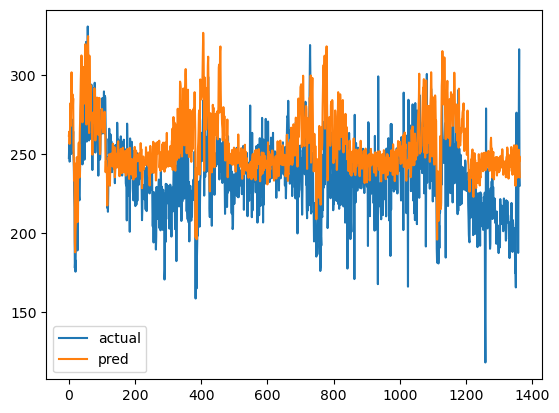

In [37]:
import matplotlib.pyplot as plt

plt.plot(labels_df.values, label="actual")
plt.plot(predictions.values, label="pred")
plt.legend()
plt.show()

In [42]:
auto_ml_job_name

'automl-pcd-20250116-22-36'

## Load Canvas AutoML model

In [44]:
best_candidate_1 = sm.describe_auto_ml_job_v2(AutoMLJobName="Canvas1734649444174")["BestCandidate"]
best_candidate_name_1 = best_candidate_1["CandidateName"]

In [45]:
best_candidate_name_1

'Canvas1734649444174-trial-t1-1'

In [46]:
print("\n")
print("CandidateName: " + best_candidate_name_1)
print(
    "FinalAutoMLJobObjectiveMetricName: "
    + best_candidate_1["FinalAutoMLJobObjectiveMetric"]["MetricName"]
)
print(
    "FinalAutoMLJobObjectiveMetricValue: "
    + str(best_candidate_1["FinalAutoMLJobObjectiveMetric"]["Value"])
)
print("\nBest candidate details:: " + str(best_candidate_1))



CandidateName: Canvas1734649444174-trial-t1-1
FinalAutoMLJobObjectiveMetricName: R2
FinalAutoMLJobObjectiveMetricValue: 0.4568800628185272

Best candidate details:: {'CandidateName': 'Canvas1734649444174-trial-t1-1', 'FinalAutoMLJobObjectiveMetric': {'Type': 'Maximize', 'MetricName': 'R2', 'Value': 0.4568800628185272, 'StandardMetricName': 'R2'}, 'ObjectiveStatus': 'Succeeded', 'CandidateSteps': [{'CandidateStepType': 'AWS::SageMaker::TrainingJob', 'CandidateStepArn': 'arn:aws:sagemaker:ap-southeast-2:851725470721:training-job/Canvas1734649444174-t1-1-ab13d1607d2f468b800d6fb265b8d19f9c1cca', 'CandidateStepName': 'Canvas1734649444174-t1-1-ab13d1607d2f468b800d6fb265b8d19f9c1cca'}], 'CandidateStatus': 'Completed', 'InferenceContainers': [{'Image': '763104351884.dkr.ecr.ap-southeast-2.amazonaws.com/autogluon-inference:0.4.3-cpu-py38-ubuntu20.04', 'ModelDataUrl': 's3://sagemaker-ap-southeast-2-851725470721/Canvas/default-20240711t130962/Training/output/Canvas1734649444174/sagemaker-automl

In [64]:
response

{'AutoMLJobName': 'Canvas1734649444174',
 'AutoMLJobArn': 'arn:aws:sagemaker:ap-southeast-2:851725470721:automl-job/Canvas1734649444174',
 'AutoMLJobInputDataConfig': [{'ChannelType': 'training',
   'ContentType': 'text/csv;header=present',
   'CompressionType': 'None',
   'DataSource': {'S3DataSource': {'S3DataType': 'S3Prefix',
     'S3Uri': 's3://sagemaker-ap-southeast-2-851725470721/Canvas/default-20240711t130962/Datasets/80a35559-74dc-4851-ba61-032d4f3da5cf/1734649432.707784'}}}],
 'OutputDataConfig': {'S3OutputPath': 's3://sagemaker-ap-southeast-2-851725470721/Canvas/default-20240711t130962/Training/output/'},
 'RoleArn': 'arn:aws:iam::851725470721:role/service-role/AmazonSageMaker-ExecutionRole-20240711T130963',
 'AutoMLJobObjective': {'MetricName': 'R2'},
 'AutoMLProblemTypeConfig': {'TabularJobConfig': {'CandidateGenerationConfig': {},
   'CompletionCriteria': {'MaxCandidates': 1},
   'FeatureSpecificationS3Uri': 's3://sagemaker-ap-southeast-2-851725470721/Canvas/default-20240

In [63]:
best_candidate_1

{'CandidateName': 'Canvas1734649444174-trial-t1-1',
 'FinalAutoMLJobObjectiveMetric': {'Type': 'Maximize',
  'MetricName': 'R2',
  'Value': 0.4568800628185272,
  'StandardMetricName': 'R2'},
 'ObjectiveStatus': 'Succeeded',
 'CandidateSteps': [{'CandidateStepType': 'AWS::SageMaker::TrainingJob',
   'CandidateStepArn': 'arn:aws:sagemaker:ap-southeast-2:851725470721:training-job/Canvas1734649444174-t1-1-ab13d1607d2f468b800d6fb265b8d19f9c1cca',
   'CandidateStepName': 'Canvas1734649444174-t1-1-ab13d1607d2f468b800d6fb265b8d19f9c1cca'}],
 'CandidateStatus': 'Completed',
 'InferenceContainers': [{'Image': '763104351884.dkr.ecr.ap-southeast-2.amazonaws.com/autogluon-inference:0.4.3-cpu-py38-ubuntu20.04',
   'ModelDataUrl': 's3://sagemaker-ap-southeast-2-851725470721/Canvas/default-20240711t130962/Training/output/Canvas1734649444174/sagemaker-automl-candidates/model/Canvas1734649444174-trial-t1-1/model.tar.gz',
   'Environment': {'SAGEMAKER_DEFAULT_INVOCATIONS_ACCEPT': 'text/csv',
    'SAGEMAK

In [70]:
bucket_name

'niwa-water-demand-modelling'

In [72]:
best_candidate_name_1

'Canvas1734649444174-trial-t1-1'

In [73]:
best_candidate_1['InferenceContainers']

[{'Image': '763104351884.dkr.ecr.ap-southeast-2.amazonaws.com/autogluon-inference:0.4.3-cpu-py38-ubuntu20.04',
  'ModelDataUrl': 's3://sagemaker-ap-southeast-2-851725470721/Canvas/default-20240711t130962/Training/output/Canvas1734649444174/sagemaker-automl-candidates/model/Canvas1734649444174-trial-t1-1/model.tar.gz',
  'Environment': {'SAGEMAKER_DEFAULT_INVOCATIONS_ACCEPT': 'text/csv',
   'SAGEMAKER_INFERENCE_OUTPUT': 'predicted_label',
   'SAGEMAKER_INFERENCE_SUPPORTED': 'predicted_label',
   'SAGEMAKER_PROGRAM': 'tabular_serve.py',
   'SAGEMAKER_SUBMIT_DIRECTORY': '/opt/ml/model/code'}}]

In [74]:
import sagemaker
import boto3
# from sagemaker.model import Model
from sagemaker import get_execution_role
from time import gmtime, strftime, sleep

role = get_execution_role()
region = boto3.Session().region_name

# Initialize the SageMaker client
sagemaker_client = boto3.client('sagemaker')

# This is the client we will use to interact with SageMaker Autopilot
sm = boto3.Session().client(service_name="sagemaker", region_name=region)

# Describe the AutoML job using the V2 API
auto_ml_job_name_1 = "Canvas1734649444174"
response = sagemaker_client.describe_auto_ml_job_v2(AutoMLJobName=auto_ml_job_name_1)

# Extract the best candidate details
best_candidate_1 = response['BestCandidate']
best_candidate_name_1 = best_candidate_1['CandidateName']
model_artifacts_1 = best_candidate_1['InferenceContainers'][0]['ModelDataUrl']
image_uri_1 = best_candidate_1['InferenceContainers'][0]['Image']
best_candidate_containers = best_candidate_1['InferenceContainers'] 

reponse = sm.create_model(
    ModelName = best_candidate_name_1,
    ExecutionRoleArn = role,
    Containers = best_candidate_containers
)


INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


In [75]:
reponse

{'ModelArn': 'arn:aws:sagemaker:ap-southeast-2:851725470721:model/Canvas1734649444174-trial-t1-1',
 'ResponseMetadata': {'RequestId': 'b8658ee9-09da-44f8-82c7-4cae4e577aad',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'b8658ee9-09da-44f8-82c7-4cae4e577aad',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '97',
   'date': 'Fri, 17 Jan 2025 05:04:08 GMT'},
  'RetryAttempts': 0}}

In [104]:
import boto3
from io import StringIO

# Initialize the S3 client
s3 = boto3.client('s3')

# Define the S3 bucket and prefix
bucket_name = 'niwa-water-demand-modelling'
prefix = 'Simulation/'

# List objects in the specified S3 path
response = s3.list_objects_v2(Bucket=bucket_name, Prefix=prefix)

# Loop through the objects and look for CSV files containing "Final_"
csv_files = []
for obj in response.get('Contents', []):
    key = obj['Key']
    if 'Final_' in key and key.endswith('.csv'):
        csv_files.append(key)

# Print the list of CSV files
# for csv_file in csv_files:
# for csv_file in ["Simulation/Final_HydroClimaticFile_ACCESS-CM2_ssp370/NorthWellingtonMoa/North Wellington Moa.csv"]:
for csv_file in ['NorthWellingtonMoa/North Wellington Moa.csv']:
    print(f"s3://{bucket_name}/{csv_file}")
    obj = s3.get_object(Bucket=bucket_name, Key=csv_file)
    # Read the CSV file content
    data = obj['Body'].read().decode('utf-8')
    # Convert to DataFrame
    df = pd.read_csv(StringIO(data))
    target = csv_file.split("/")[-1].split(".csv")[0]
    columns = [e for e in df.columns if e not in ["Date", target, "replicate"]]
    # Convert the DataFrame to a CSV string
    csv_buffer = StringIO()
    df[columns].to_csv(csv_buffer, index=False, header=False)
    # Upload the CSV string to S3
    file_name = csv_file.split("/")[-1]
    object_key = f"TransformedInputs/batch_transform/input/{file_name}"
    s3.put_object(Bucket=bucket_name, Key=object_key, Body=csv_buffer.getvalue())


s3://niwa-water-demand-modelling/NorthWellingtonMoa/North Wellington Moa.csv


In [105]:
df.dtypes

Date                            object
doy                              int64
Aquifer                        float64
PE                               int64
month                            int64
mday                             int64
is_holiday                       int64
wday                             int64
API                            float64
lagAPI                         float64
Tmax                             int64
Tmaxlag1                       float64
Sun                            float64
Sunlag1                        float64
WVRain                         float64
KerburnRain                      int64
Rain_L7DAYS                    float64
Rain_L6DAYS                    float64
Rain_L5DAYS                    float64
Rain_L4DAYS                    float64
Rain_L3DAYS                    float64
Rain_L2DAYS                    float64
Season                           int64
Rainlag1                       float64
Rainlag2                       float64
Rainlag3                 

In [14]:
# Create a SageMaker session
sagemaker_session = sagemaker.Session()

timestamp_suffix = strftime("%Y%m%d-%H%M%S", gmtime())
transform_job_name=f'{best_candidate_name}-' + timestamp_suffix
print("BatchTransformJob: " + transform_job_name)

input_prefix = "TransformedInputs"
output_prefix = "TrainingDataInference"

response = sm.create_transform_job(
    TransformJobName=transform_job_name, 
    ModelName=best_candidate_name,
    MaxPayloadInMB=100,
    ModelClientConfig={
        'InvocationsTimeoutInSeconds': 3600
    },
    TransformInput={
        'DataSource': {
            'S3DataSource': {
                'S3DataType': 'S3Prefix',
                'S3Uri': 's3://{}/{}/batch_transform/input'.format(bucket_name, input_prefix)
            }
        },
        'ContentType': 'text/csv',
        'SplitType': 'Line'
    },
    TransformOutput={
        'S3OutputPath': 's3://{}/{}/batch_transform/output/'.format(bucket_name, output_prefix),
        'AssembleWith': 'Line',
    },
    TransformResources={
        'InstanceType': 'ml.c5.4xlarge',#'ml.m5.12xlarge',
        'InstanceCount': 1
    }
    )

BatchTransformJob: Canvas1734649444174-trial-t1-1-20250121-003918


In [15]:
import datetime

describe_response = sm.describe_transform_job(TransformJobName=transform_job_name)

job_run_status = describe_response["TransformJobStatus"]

while job_run_status not in ("Failed", "Completed", "Stopped"):
    describe_response = sm.describe_transform_job(TransformJobName=transform_job_name)
    job_run_status = describe_response["TransformJobStatus"]

    print(
       datetime.datetime.now(), describe_response["TransformJobStatus"]
    )
    sleep(60)

2025-01-21 00:39:22.589267 InProgress
2025-01-21 00:40:22.707896 InProgress
2025-01-21 00:41:22.839579 InProgress
2025-01-21 00:42:22.961887 InProgress
2025-01-21 00:43:23.087095 InProgress
2025-01-21 00:44:23.209799 Completed


In [91]:
describe_response

{'TransformJobName': 'Canvas1734649444174-trial-t1-1-20250117-060821',
 'TransformJobArn': 'arn:aws:sagemaker:ap-southeast-2:851725470721:transform-job/Canvas1734649444174-trial-t1-1-20250117-060821',
 'TransformJobStatus': 'Failed',
 'FailureReason': 'ClientError: See job logs for more information',
 'ModelName': 'Canvas1734649444174-trial-t1-1',
 'ModelClientConfig': {'InvocationsTimeoutInSeconds': 3600},
 'MaxPayloadInMB': 20,
 'TransformInput': {'DataSource': {'S3DataSource': {'S3DataType': 'S3Prefix',
    'S3Uri': 's3://niwa-water-demand-modelling/TransformedInputs/Simulation/Final_HydroClimaticFile_ACCESS-CM2_ssp370/NorthWellingtonMoa/'}},
  'ContentType': 'text/csv',
  'CompressionType': 'None',
  'SplitType': 'None'},
 'TransformOutput': {'S3OutputPath': 's3://niwa-water-demand-modelling/TrainingDataInference/',
  'AssembleWith': 'Line',
  'KmsKeyId': ''},
 'TransformResources': {'InstanceType': 'ml.c5.4xlarge', 'InstanceCount': 1},
 'CreationTime': datetime.datetime(2025, 1, 1

# Use models already trained Canvas for Inference

## data prep, find simulation folders, find site folders under the respective simulation folder

In [4]:
import boto3
from io import StringIO

# Initialize the S3 client
s3 = boto3.client('s3')

# Define the S3 bucket and prefix
bucket_name = 'niwa-water-demand-modelling'
prefix = 'Simulation/'

# List objects in the specified S3 path
response = s3.list_objects_v2(Bucket=bucket_name, Prefix=prefix)

# Loop through the objects and look for CSV files containing "Final_"
csv_files = []
for obj in response.get('Contents', []):
    key = obj['Key']
    if 'Final_' in key and key.endswith('.csv'):
        csv_files.append(key)


In [3]:
auto_ml_job_dict = {
    'NorthWellingtonMoa': 'Canvas1734649444174',
    'WellingtonLowLevel': 'Canvas1734648978161',
    'Petone': 'Canvas1733434154045',
    'WellingtonHighWestern': 'Canvas1733085655509',
    'WellingtonHighMoa': 'Canvas1733372214860',
    'NorthWellingtonPorirua': 'Canvas1733369877242',
    'Porirua': 'Canvas1733437572452',
    'Wainuiomata': 'Canvas1734649248674',
    'UpperHutt': 'Canvas1734649294393',
    'LowerHutt': 'Canvas1734649384856'
}

In [8]:
list(auto_ml_job_dict.items())

[('NorthWellingtonMoa', 'Canvas1734649444174'),
 ('WellingtonLowLevel', 'Canvas1734648978161'),
 ('Petone', 'Canvas1733434154045'),
 ('WellingtonHighWestern', 'Canvas1733085655509'),
 ('WellingtonHighMoa', 'Canvas1733372214860'),
 ('NorthWellingtonPorirua', 'Canvas1733369877242'),
 ('Porirua', 'Canvas1733437572452'),
 ('Wainuiomata', 'Canvas1734649248674'),
 ('UpperHutt', 'Canvas1734649294393'),
 ('LowerHutt', 'Canvas1734649384856')]

## create model first using autoML job_id saved in the auto_ml_job_list

In [1]:
import sagemaker
import boto3
import datetime
from io import StringIO
import io
import pandas as pd
import numpy as np
# from sagemaker.model import Model
from sagemaker import get_execution_role
from time import gmtime, strftime, sleep
from botocore.exceptions import ClientError

role = get_execution_role()
region = boto3.Session().region_name

# Initialize the SageMaker client
sagemaker_client = boto3.client('sagemaker')

# This is the client we will use to interact with SageMaker Autopilot
sm = boto3.Session().client(service_name="sagemaker", region_name=region)

for site_name, auto_ml_job_name in list(auto_ml_job_dict.items())[0:1]:
    # Describe the AutoML job using the V2 API
    # auto_ml_job_name_1 = "Canvas1734649444174"
    response = sagemaker_client.describe_auto_ml_job_v2(AutoMLJobName=auto_ml_job_name)
    
    # Extract the best candidate details
    best_candidate = response['BestCandidate']
    best_candidate_name = best_candidate['CandidateName']
    model_artifacts = best_candidate['InferenceContainers'][0]['ModelDataUrl']
    image_uri = best_candidate['InferenceContainers'][0]['Image']
    best_candidate_containers = best_candidate['InferenceContainers'] 

    # model = sm.create_model(
    #     ModelName = best_candidate_name,
    #     ExecutionRoleArn = role,
    #     Containers = best_candidate_containers
    # )

    # check if model exist
    try:
        response = sm.describe_model(ModelName=best_candidate_name)
        print(f"Model {best_candidate_name} exists. Loading the model.")
    # Load the model logic here
    except ClientError as e:
        if e.response['Error']['Code'] == 'ValidationException':
            print(f"Model {best_candidate_name} does not exist. Creating the model.")
            response = sm.create_model(
                ModelName=best_candidate_name,
                ExecutionRoleArn=role,
                Containers=best_candidate_containers
            )
            print(f"Model {model_name} created successfully.")
        else:
            print(f"Unexpected error: {e}")

    # Find all s3 paths for the same site
    input_files = [e for e in csv_files if site_name in e]
    for csv_file in input_files[1:2]:
        print(f"s3://{bucket_name}/{csv_file}")
        obj = s3.get_object(Bucket=bucket_name, Key=csv_file)
        # Read the CSV file content
        data = obj['Body'].read().decode('utf-8')
        # Convert to DataFrame
        df = pd.read_csv(StringIO(data))
        target = csv_file.split("/")[-1].split(".csv")[0]
        columns = [e for e in df.columns if e not in ["Date", target, "replicate"]]
        
        # Upload the CSV string to S3
        file_name = csv_file.split("/")[-1]
        
        # Split the data into smaller chunks
        chunk_size = 5000  # Adjust the chunk size as needed
        chunks = [df[i:i + chunk_size] for i in range(0, df.shape[0], chunk_size)]

        # Upload the chunks to S3
        input_chunk_key_list = []
        for idx, chunk in enumerate(chunks):
            csv_buffer = StringIO()
            chunk[columns].to_csv(csv_buffer, index=False, header=False)
            chunk_csv_path = csv_file.replace(".csv", f"_{idx}.csv")
            chunk_key = f"TransformedInputs/{chunk_csv_path}"
            s3.put_object(Bucket=bucket_name, Key=chunk_key, Body=csv_buffer.getvalue())
            print(f"Uploaded chunk {idx} to s3://{bucket_name}/{chunk_key}")
            input_chunk_key_list.append(chunk_key)
    

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


NameError: name 'auto_ml_job_dict' is not defined

In [38]:
chunk_key

'TransformedInputs/Simulation/Final_HydroClimaticFile_ACCESS-CM2_ssp370/NorthWellingtonMoa/North Wellington Moa_9.csv'

In [39]:
best_candidate_name

'Canvas1734649444174-trial-t1-1'

In [40]:
import re

def convert_input_to_output_key(input_key):
    # Split the input key by '/'
    parts = input_key.split('/')
    # Remove the first part 'TransformedInputs'
    parts.pop(0)
    # Remove the last part which is the file name
    parts.pop()
    # Join the remaining parts to form the output key
    output_key = '/'.join(parts)
    return output_key

def extract_number(input_string):
    # Use regular expression to find the number before '.csv'
    match = re.search(r'_(\d+)\.csv$', input_string)
    if match:
        return int(match.group(1))
    else:
        return None

In [59]:
def schedule_job(best_candidate_name, input_chunk_key, output_chunk_key, instance_type, bucket_name):
    # Create a SageMaker session
    sagemaker_session = sagemaker.Session()
    timestamp_suffix = strftime("%Y%m%d-%H%M%S", gmtime())
    chunk_idx = extract_number(input_chunk_key)
    transform_job_name=f'{best_candidate_name}-c{chunk_idx}-' + timestamp_suffix
    print(f"BatchTransformJob ({instance_type}): {transform_job_name} on {input_chunk_key}")
    
    input_prefix = input_chunk_key
    output_prefix = f"TransformedOutputs/{output_chunk_key}"
    
    response = sm.create_transform_job(
        TransformJobName=transform_job_name, 
        ModelName=best_candidate_name,
        MaxPayloadInMB=20,
        BatchStrategy="MultiRecord",
        ModelClientConfig={
            'InvocationsTimeoutInSeconds': 3600
        },
        TransformInput={
            'DataSource': {
                'S3DataSource': {
                    'S3DataType': 'S3Prefix',
                    'S3Uri': 's3://{}/{}'.format(bucket_name, input_prefix)
                }
            },
            'ContentType': 'text/csv',
            'SplitType': 'Line'
        },
        TransformOutput={
            'S3OutputPath': 's3://{}/{}'.format(bucket_name, output_prefix),
            'AssembleWith': 'Line',
        },
        TransformResources={
            'InstanceType': instance_type, #'ml.c5.4xlarge', 'ml.m5.12xlarge',
            'InstanceCount': 1
        }
        )
    return transform_job_name

def check_job_status(transform_job_name):
    while True:
        describe_response = sm.describe_transform_job(TransformJobName=transform_job_name)
        job_run_status = describe_response["TransformJobStatus"]
        if job_run_status in ("Failed", "Completed", "Stopped"):
            print(f"{datetime.datetime.now()} {describe_response['TransformJobStatus']}")
            break
        print(f"{datetime.datetime.now()} {describe_response['TransformJobStatus']}")
        sleep(60)

In [61]:
def get_job_status(job):
    describe_response = sm.describe_transform_job(TransformJobName=job)
    job_run_status = describe_response["TransformJobStatus"]
    return job_run_status

def schedule_batch_transform_jobs(best_candidate_name, input_chunk_key_list, output_chunk_key_list, instance_types, bucket_name):
    running_jobs = {instance_type: [] for instance_type in instance_types}
    max_parallel_jobs = 4
    input_index = 0

    while input_index < len(input_chunk_key_list):
        for instance_type in instance_types:
            while len(running_jobs[instance_type]) < max_parallel_jobs and input_index < len(input_chunk_key_list):
                # Schedule a new job
                input_chunk_key = input_chunk_key_list[input_index]
                output_chunk_key = output_chunk_key_list[input_index]
                transform_job_name = schedule_job(best_candidate_name, input_chunk_key, output_chunk_key, instance_type, bucket_name)
                running_jobs[instance_type].append(transform_job_name)
                input_index += 1

        # Check the status of running jobs and remove completed jobs from the list
        all_running_jobs = []
        for instance_type in instance_types:
            for job in running_jobs[instance_type]:
                check_job_status(job)
            job_status_x = [job for job in running_jobs[instance_type] if get_job_status(job) not in ("Failed", "Completed", "Stopped")]
            running_jobs[instance_type] = job_status_x
            all_running_jobs.extend(job_status_x)
        
        if len(all_running_jobs) > 0:
            sleep(60)  # jobs running, Wait before checking again
        else:
            sleep(1)  # no jobs running, don't sleep

    # Wait for all remaining jobs to complete
    for instance_type in instance_types:
        while running_jobs[instance_type]:
            for job in running_jobs[instance_type]:
                check_job_status(job)
            job_status_x = [job for job in running_jobs[instance_type] if get_job_status(job) not in ("Failed", "Completed", "Stopped")]
            running_jobs[instance_type] = job_status_x
            if len(job_status_x) > 0:
                sleep(60)  # jobs running, Wait before checking again
            else:
                sleep(1)  # no jobs running, don't sleep

In [62]:
output_chunk_key_list = [convert_input_to_output_key(e) for e in input_chunk_key_list]
instance_types = ['ml.m5.xlarge', 'ml.c5.xlarge', 'ml.m5.2xlarge']
schedule_batch_transform_jobs(best_candidate_name, input_chunk_key_list, output_chunk_key_list, instance_types, bucket_name)

BatchTransformJob (ml.m5.xlarge): Canvas1734649444174-trial-t1-1-c0-20250121-042939 on TransformedInputs/Simulation/Final_HydroClimaticFile_AWI-CM-1-1-MR_ssp126/NorthWellingtonMoa/North Wellington Moa_0.csv
BatchTransformJob (ml.m5.xlarge): Canvas1734649444174-trial-t1-1-c1-20250121-042940 on TransformedInputs/Simulation/Final_HydroClimaticFile_AWI-CM-1-1-MR_ssp126/NorthWellingtonMoa/North Wellington Moa_1.csv
BatchTransformJob (ml.m5.xlarge): Canvas1734649444174-trial-t1-1-c2-20250121-042941 on TransformedInputs/Simulation/Final_HydroClimaticFile_AWI-CM-1-1-MR_ssp126/NorthWellingtonMoa/North Wellington Moa_2.csv
BatchTransformJob (ml.c5.xlarge): Canvas1734649444174-trial-t1-1-c3-20250121-042942 on TransformedInputs/Simulation/Final_HydroClimaticFile_AWI-CM-1-1-MR_ssp126/NorthWellingtonMoa/North Wellington Moa_3.csv
BatchTransformJob (ml.c5.xlarge): Canvas1734649444174-trial-t1-1-c4-20250121-042943 on TransformedInputs/Simulation/Final_HydroClimaticFile_AWI-CM-1-1-MR_ssp126/NorthWellin

KeyboardInterrupt: 

In [54]:
bucket_name

'niwa-water-demand-modelling'

In [48]:
best_candidate_name

'Canvas1734649444174-trial-t1-1'

In [28]:
job_list

['Canvas1734649444174-trial-t1-1-c0-20250121-021152',
 'Canvas1734649444174-trial-t1-1-c1-20250121-021153',
 'Canvas1734649444174-trial-t1-1-c2-20250121-021154']

In [31]:
# wait for batch transform job to complete
transform_job_name = job_list[2]
describe_response = sm.describe_transform_job(TransformJobName=transform_job_name)
job_run_status = describe_response["TransformJobStatus"]
while job_run_status not in ("Failed", "Completed", "Stopped"):
    describe_response = sm.describe_transform_job(TransformJobName=transform_job_name)
    job_run_status = describe_response["TransformJobStatus"]

    print(
       datetime.datetime.now(), describe_response["TransformJobStatus"]
    )
    sleep(60)

In [17]:
[e for e in csv_files if site_name in e]

['Simulation/Final_HydroClimaticFile_ACCESS-CM2_ssp370/NorthWellingtonMoa/North Wellington Moa.csv',
 'Simulation/Final_HydroClimaticFile_AWI-CM-1-1-MR_ssp126/NorthWellingtonMoa/North Wellington Moa.csv',
 'Simulation/Final_HydroClimaticFile_AWI-CM-1-1-MR_ssp245/NorthWellingtonMoa/North Wellington Moa.csv',
 'Simulation/Final_HydroClimaticFile_AWI-CM-1-1-MR_ssp370/NorthWellingtonMoa/North Wellington Moa.csv',
 'Simulation/Final_HydroClimaticFile_CNRM-CM6-1_ssp126/NorthWellingtonMoa/North Wellington Moa.csv',
 'Simulation/Final_HydroClimaticFile_CNRM-CM6-1_ssp245/NorthWellingtonMoa/North Wellington Moa.csv',
 'Simulation/Final_HydroClimaticFile_CNRM-CM6-1_ssp370/NorthWellingtonMoa/North Wellington Moa.csv',
 'Simulation/Final_HydroClimaticFile_EC-Earth3_ssp126/NorthWellingtonMoa/North Wellington Moa.csv',
 'Simulation/Final_HydroClimaticFile_EC-Earth3_ssp245/NorthWellingtonMoa/North Wellington Moa.csv',
 'Simulation/Final_HydroClimaticFile_EC-Earth3_ssp370/NorthWellingtonMoa/North Welli

In [ ]:
import pandas as pd
import boto3
from io import StringIO

# Load the input data from S3
s3 = boto3.client('s3')
bucket_name = 'niwa-water-demand-modelling'
object_key = 'TrainingData/North Wellington Moa.csv'

response = s3.get_object(Bucket=bucket_name, Key=object_key)
data = pd.read_csv(response['Body'])

# Split the data into smaller chunks
chunk_size = 1000  # Adjust the chunk size as needed
chunks = [data[i:i + chunk_size] for i in range(0, data.shape[0], chunk_size)]

# Upload the chunks to S3
for idx, chunk in enumerate(chunks):
    csv_buffer = StringIO()
    chunk.to_csv(csv_buffer, index=False)
    chunk_key = f'TrainingData/North Wellington Moa_chunk_{idx}.csv'
    s3.put_object(Bucket=bucket_name, Key=chunk_key, Body=csv_buffer.getvalue())
    print(f"Uploaded chunk {idx} to s3://{bucket_name}/{chunk_key}")

## data prep, for respective site files under all simulation folders and process each of them

In [ ]:
# Print the list of CSV files
# for csv_file in csv_files:
# for csv_file in ["Simulation/Final_HydroClimaticFile_ACCESS-CM2_ssp370/NorthWellingtonMoa/North Wellington Moa.csv"]:
for csv_file in ['NorthWellingtonMoa/North Wellington Moa.csv']:
    print(f"s3://{bucket_name}/{csv_file}")
    obj = s3.get_object(Bucket=bucket_name, Key=csv_file)
    # Read the CSV file content
    data = obj['Body'].read().decode('utf-8')
    # Convert to DataFrame
    df = pd.read_csv(StringIO(data))
    target = csv_file.split("/")[-1].split(".csv")[0]
    columns = [e for e in df.columns if e not in ["Date", target, "replicate"]]
    # Convert the DataFrame to a CSV string
    csv_buffer = StringIO()
    df[columns].to_csv(csv_buffer, index=False, header=False)
    # Upload the CSV string to S3
    file_name = csv_file.split("/")[-1]
    object_key = f"TransformedInputs/batch_transform/input/{file_name}"
    s3.put_object(Bucket=bucket_name, Key=object_key, Body=csv_buffer.getvalue())

In [59]:

transformer = model.transformer(
    instance_count=1,
    instance_type="ml.c5.4xlarge",
    assemble_with="Line",
    strategy="SingleRecord",
    output_path="s3://niwa-water-demand-modelling/TrainingDataInference/",
    env={"SAGEMAKER_MODEL_SERVER_TIMEOUT": "100", "SAGEMAKER_MODEL_SERVER_WORKERS": "1"},
)

transformer.transform(
    data="s3://niwa-water-demand-modelling/TrainingData/North Wellington Moa.csv",
    split_type="Line",
    content_type="text/csv",
    wait=False,
    model_client_config={"InvocationsTimeoutInSeconds": 80, "InvocationsMaxRetries": 1},
)

print("Starting transform job {}".format(transformer._current_job_name))

INFO:sagemaker:Creating model with name: autogluon-inference-2025-01-17-03-20-46-885
INFO:sagemaker:Creating transform job with name: autogluon-inference-2025-01-17-03-20-47-513


Starting transform job autogluon-inference-2025-01-17-03-20-47-513


In [60]:
## Wait for jobs to finish
pending_complete = True
job_name = transformer._current_job_name

while pending_complete:
    pending_complete = False

    description = sm.describe_transform_job(TransformJobName=job_name)
    if description["TransformJobStatus"] not in ["Failed", "Completed"]:
        pending_complete = True

    print("{} transform job is running.".format(job_name))
    time.sleep(60)

print("\nCompleted.")

autogluon-inference-2025-01-17-03-20-47-513 transform job is running.
autogluon-inference-2025-01-17-03-20-47-513 transform job is running.
autogluon-inference-2025-01-17-03-20-47-513 transform job is running.
autogluon-inference-2025-01-17-03-20-47-513 transform job is running.
autogluon-inference-2025-01-17-03-20-47-513 transform job is running.
autogluon-inference-2025-01-17-03-20-47-513 transform job is running.

Completed.


---
## Cleanup

The Autopilot job creates many underlying artifacts such as dataset splits, preprocessing scripts, or preprocessed data, etc. This code, when un-commented, deletes them. 

In [ ]:
s3 = boto3.resource("s3")
s3_bucket = s3.Bucket(bucket)

print(s3_bucket)
job_outputs_prefix = "{}/output/{}".format(prefix, auto_ml_job_name)
print(job_outputs_prefix)

# Delete S3 objects
s3_bucket.objects.filter(Prefix=job_outputs_prefix).delete()

We then delete all the experiment and model resources created by the Autopilot experiment.

In [ ]:
def cleanup_experiment_resources(experiment_name):
    trials = sm.list_trials(ExperimentName=experiment_name)["TrialSummaries"]
    print("TrialNames:")
    for trial in trials:
        trial_name = trial["TrialName"]
        print(f"\n{trial_name}")

        components_in_trial = sm.list_trial_components(TrialName=trial_name)
        print("\tTrialComponentNames:")
        for component in components_in_trial["TrialComponentSummaries"]:
            component_name = component["TrialComponentName"]
            print(f"\t{component_name}")
            sm.disassociate_trial_component(TrialComponentName=component_name, TrialName=trial_name)
            try:
                # comment out to keep trial components
                sm.delete_trial_component(TrialComponentName=component_name)
            except:
                # component is associated with another trial
                continue
            # to prevent throttling
            time.sleep(5)
        sm.delete_trial(TrialName=trial_name)
    sm.delete_experiment(ExperimentName=experiment_name)
    print(f"\nExperiment {experiment_name} deleted")


def cleanup_autopilot_models(autopilot_job_name):
    print("{0}:\n".format(autopilot_job_name))
    response = sm.list_models(NameContains=autopilot_job_name)

    for model in response["Models"]:
        model_name = model["ModelName"]
        print(f"\t{model_name}")
        sm.delete_model(ModelName=model_name)
        # to prevent throttling
        time.sleep(3)

In [ ]:
cleanup_experiment_resources("{0}-aws-auto-ml-job".format(auto_ml_job_name))

In [ ]:
cleanup_autopilot_models(auto_ml_job_name)

Finally, the following code, when uncommented, will delete the local files used in this demo.

In [ ]:
import shutil
import glob
import os


def delete_local_files():
    base_path = ""
    dir_list = glob.iglob(os.path.join(base_path, "{0}*".format(auto_ml_job_name)))

    for path in dir_list:
        if os.path.isdir(path):
            shutil.rmtree(path)

    if os.path.exists("CaliforniaHousing"):
        shutil.rmtree("CaliforniaHousing")

    if os.path.exists("cal_housing.tgz"):
        os.remove("cal_housing.tgz")

    if os.path.exists("SageMakerAutopilotCandidateDefinitionNotebook.ipynb"):
        os.remove("SageMakerAutopilotCandidateDefinitionNotebook.ipynb")

    if os.path.exists("SageMakerAutopilotDataExplorationNotebook.ipynb"):
        os.remove("SageMakerAutopilotDataExplorationNotebook.ipynb")

    if os.path.exists("test_data_no_target.csv"):
        os.remove("test_data_no_target.csv")

    if os.path.exists("test_data.csv"):
        os.remove("test_data.csv")

    if os.path.exists("train_data.csv"):
        os.remove("train_data.csv")


## UNCOMMENT TO CLEAN UP LOCAL FILES
# delete_local_files()

**Note: If you enabled automatic endpoint creation, you will need to delete the endpoint manually.**

## Notebook CI Test Results

This notebook was tested in multiple regions. The test results are as follows, except for us-west-2 which is shown at the top of the notebook.

![This us-east-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/us-east-1/autopilot|autopilot_california_housing.ipynb)

![This us-east-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/us-east-2/autopilot|autopilot_california_housing.ipynb)

![This us-west-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/us-west-1/autopilot|autopilot_california_housing.ipynb)

![This ca-central-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ca-central-1/autopilot|autopilot_california_housing.ipynb)

![This sa-east-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/sa-east-1/autopilot|autopilot_california_housing.ipynb)

![This eu-west-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/eu-west-1/autopilot|autopilot_california_housing.ipynb)

![This eu-west-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/eu-west-2/autopilot|autopilot_california_housing.ipynb)

![This eu-west-3 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/eu-west-3/autopilot|autopilot_california_housing.ipynb)

![This eu-central-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/eu-central-1/autopilot|autopilot_california_housing.ipynb)

![This eu-north-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/eu-north-1/autopilot|autopilot_california_housing.ipynb)

![This ap-southeast-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ap-southeast-1/autopilot|autopilot_california_housing.ipynb)

![This ap-southeast-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ap-southeast-2/autopilot|autopilot_california_housing.ipynb)

![This ap-northeast-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ap-northeast-1/autopilot|autopilot_california_housing.ipynb)

![This ap-northeast-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ap-northeast-2/autopilot|autopilot_california_housing.ipynb)

![This ap-south-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ap-south-1/autopilot|autopilot_california_housing.ipynb)
